<a href="https://colab.research.google.com/github/hossein20s/Average_Blood_Pressure_estimation/blob/master/Ramtin_code_via_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
window_size = 80
batch_size = 64
initial_epoch = 0
epochs = 200
n_time_steps = 80


DATA_FILE = 'data/sample01.csv'
#columns = ["RelativeTimeMilliseconds", "NBP (Mean)", "Minute Volume"]
columns = ["NBP (Mean)", "Minute Volume"]


In [0]:
#!rm -r notebook_snippets
!git clone https://github.com/hossein20s/notebook_snippets
!cd /content/notebook_snippets/; git pull 
#!cd /content/notebook_snippets/; git config --global user.email "hossein@vitachain.app"; git config --global user.name "hossein20s"; git checkout d4ee6b1487d0a3d0d14f2299364c56bf0f588dbd
#!cd /content/notebook_snippets/; cat datautil.py
import sys
sys.path.append('notebook_snippets')
import importlib
import modelutil
importlib.reload(modelutil)

fatal: destination path 'notebook_snippets' already exists and is not an empty directory.
Already up to date.
save and load models from yaml and json files defined. Everything stored in folder  <built-in function dir>


<module 'modelutil' from 'notebook_snippets/modelutil.py'>

In [0]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/models" models
!ln -s "/gdrive/My Drive/data" data
!ln -s "/gdrive/My Drive/checkpoints" checkpoints

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
ln: failed to create symbolic link 'models/models': Function not implemented
ln: failed to create symbolic link 'data/data': Function not implemented
ln: failed to create symbolic link 'checkpoints/checkpoints': Function not implemented


In [0]:
!wget -O $DATA_FILE http://storage.googleapis.com/medicalblockchain_dev/data/UniversityQueenslandVitalSignals/case01/uq_vsd_case01_trenddata.csv 

--2019-06-16 18:51:14--  http://storage.googleapis.com/medicalblockchain_dev/data/UniversityQueenslandVitalSignals/case01/uq_vsd_case01_trenddata.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 2607:f8b0:4001:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 961664 (939K) [text/csv]
Saving to: ‘data/sample01.csv’

data/sample01.csv   100%[===================>] 939.12K  --.-KB/s    in 0.01s   

2019-06-16 18:51:14 (67.2 MB/s) - ‘data/sample01.csv’ saved [961664/961664]



In [0]:
import datautil
from datautil import data_reader

reader = data_reader(DATA_FILE, columns=columns, label_index=0, window_size=window_size, batchsize=batch_size)
data_train, data_label = reader.get_shuff_train_label()


reading data from file data/sample01.csv
Raw data (7173, 54)
Dropna with selected columns (7173, 54)
[[72.   1.7]
 [72.   1.7]
 [72.   1.7]]


In [0]:
import modelutil

model = modelutil.load_model_yaml('models', 'ramtin2lstm64.epoch-' + str(initial_epoch))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

load model from file models/model.ramtin2lstm64.epoch-0.yaml
loading weights from  models/model.ramtin2lstm64.epoch-0.h5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 80, 64)            16896     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [0]:
from modelutil import PrintDot
import numpy as np

loss_metrics = model.evaluate(
  np.expand_dims(reader.val_data, axis=-1),
  reader.val_label,
  #data_train,
  #data_label,
  batch_size=batch_size,
  verbose=0
)

In [0]:
print(model.metrics_names)
print(loss_metrics)

['loss', 'mean_absolute_error']
[24.668585266876867, 3.8402737416484984]


In [0]:
model.save_weights('model.h5')

In [59]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping

from modelutil import PrintDot

model_name = 'ramtin2lstm64'
#prefix = '.checkpoint-epoch{epoch:02d}-val_acc{val_acc:.2f}'
prefix = '.epoch-' + str(epochs)
modelCheckpoint = ModelCheckpoint('checkpoints/model.' + model_name + prefix + '.h5', 
                             monitor='val_loss', verbose=0, 
                             save_best_only=True)
csvLogger = CSVLogger('checkpoints/log.' + model_name + prefix + '.csv')
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
tensorboard = TensorBoard(log_dir='checkpoints/logs', batch_size=batch_size)
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0)

callbacks = [
      PrintDot(),
      csvLogger,
      modelCheckpoint,
      tensorboard
]
history = model.fit(
  data_train,
  data_label,
  epochs=epochs,
  batch_size=batch_size,
  validation_split = 0.35,
  verbose=0,
  callbacks=callbacks,
  initial_epoch = initial_epoch
)



....................................................................................................
....................................................................................................

In [0]:
modelutil.save_model_yaml('models', model, model_name + prefix)

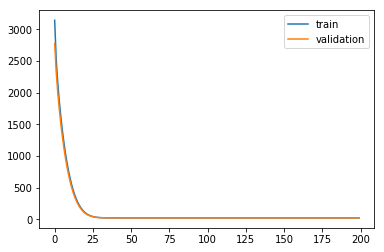

In [61]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(epochs - initial_epoch), history.history['loss'], label='train')
plt.plot(np.arange(epochs - initial_epoch), history.history['val_loss'], label='validation')
plt.legend()

# Old Stuff. Delete it later on

In [0]:

import json
!wget "bit.ly/ramtinconfig" -O config.ramtin.json
CONFIG_JSON_FILE = 'config.ramtin.json'
import os
configs = json.load(open(CONFIG_JSON_FILE, 'r'))

'''
data = DataLoader(
	os.path.join('data', configs['data']['filename']),
	configs['data']['train_test_split'],
	configs['data']['columns']
)
'''
array_size = configs['training']['feature_size']
reader = data_reader(
	os.path.join( configs['data']['filename']),
	l=array_size,
	batchsize=configs['training']['batch_size']
)


--2019-06-14 17:57:25--  http://bit.ly/ramtinconfig
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/hossein20s/Average_Blood_Pressure_estimation/master/config.ramtin.json [following]
--2019-06-14 17:57:25--  https://raw.githubusercontent.com/hossein20s/Average_Blood_Pressure_estimation/master/config.ramtin.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1153 (1.1K) [text/plain]
Saving to: ‘config.ramtin.json’

config.ramtin.json  100%[===================>]   1.13K  --.-KB/s    in 0s      

2019-06-14 17:57:25 (106 MB/s) - ‘config.ramtin.json’ saved [1153/1153]

   Unnamed: 0  Relativ

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


TypeError: ignored

In [0]:
s = [10,20]
for i in s:
  print(i)


10
20


In [0]:
dataframe = reader.df
dataframe.shape

AttributeError: ignored

In [0]:
!wget bit.ly/plot_lib -O plot_lib.ipynb
facets_display(reader.df)


--2019-06-12 03:03:13--  http://bit.ly/plot_lib
Resolving bit.ly (bit.ly)... 67.199.248.10, 67.199.248.11
Connecting to bit.ly (bit.ly)|67.199.248.10|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/hossein20s/Average_Blood_Pressure_estimation/master/plot_lib.ipynb [following]
--2019-06-12 03:03:13--  https://raw.githubusercontent.com/hossein20s/Average_Blood_Pressure_estimation/master/plot_lib.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15271 (15K) [text/plain]
Saving to: ‘plot_lib.ipynb’

plot_lib.ipynb      100%[===================>]  14.91K  --.-KB/s    in 0.01s   

2019-06-12 03:03:13 (1.20 MB/s) - ‘plot_lib.ipynb’ saved [15271/15271]



In [0]:
import os
import math
import numpy as np
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import TimeDistributed
from keras.layers import RepeatVector, Conv1D, MaxPool1D, Flatten

class TheModel():
  """A class for an building and inferencing an lstm model"""

  def __init__(self):
    self.model = Sequential()

  def load_model(self, filepath):
    print('[Model] Loading model from file %s' % filepath)
    self.model = load_model(filepath)

  def build_model(self, configs):
    timer = Timer()
    timer.start()
    timer.start()
    
    input_shape = None
    has_input_shape = False
    is_first_layer = True



    for layer in configs['model']['layers']:
      neurons = layer['neurons'] if 'neurons' in layer else None
      rate = layer['rate'] if 'rate' in layer else None
      activation = layer['activation'] if 'activation' in layer else None
      return_seq = layer['return_seq'] if 'return_seq' in layer else None
      input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else None
      input_dim = layer['input_dim'] if 'input_dim' in layer else None
      kernel_size = layer['kernel_size'] if 'kernel_size' in layer else None
      filters = layer['filters'] if 'filters' in layer else None
      strides = layer['strides'] if 'strides' in layer else 1
      print(kernel_size)
      if 'input_shape' in layer:
        input_shape = layer['input_shape']
        has_input_shape = true

      if layer['type'] == 'dense':
        if(is_first_layer):
          self.model.add(Dense(neurons, activation=activation, input_shape=input_shape))
          is_first_layer = False
        else:
          self.model.add(Dense(neurons, activation=activation))
      if layer['type'] == 'lstm' or layer['type'] == 'conv1D':
        input_shape=(input_timesteps, input_dim)
        has_input_shape = True
        if(layer['type'] == 'lstm'):
          if is_first_layer:
            self.model.add(LSTM(neurons, input_shape=input_shape, return_sequences=return_seq))
            is_first_layer = False
          else:
            self.model.add(LSTM(neurons, return_sequences=return_seq))
        if(layer['type'] == 'conv1D'):
          if is_first_layer:
            self.model.add(Conv1D(filters, kernel_size, strides=strides, activation='relu', input_shape=input_shape))
            is_first_layer = False
          else:
            self.model.add(Conv1D(filters, kernel_size, strides=strides, activation='relu'))
      if layer['type'] == 'dropout':
          self.model.add(Dropout(rate))
      if layer['type'] == 'flatten':
          self.model.add(Flatten())
      if layer['type'] == 'maxpool1D':
          self.model.add(MaxPool1D(rate))
      if layer['type'] == 'repeat_vector':
        self.model.add(RepeatVector(input_timesteps))
      if layer['type'] == 'time_distributed_dense':
        self.model.add(TimeDistributed(Dense(neurons, activation=activation)))
      if layer['type'] == 'attention_decoder':
        self.model.add(AttentionDecoder(neurons, input_dim))
      if layer['type'] == 'attention':
        self.model.add(Attention())

    print(configs['model']['metrics'])
    self.model.compile(loss='mse', 
                       optimizer=configs['model']['optimizer'],
                      metrics=configs['model']['metrics'])
    print('[Model] Model Compiled')
    print('input_shape: ',input_shape)
    if has_input_shape:
      self.model.summary()
    timer.stop()

  def fit(self, x, y, epochs, batch_size, validation_split, save_dir):
    timer = Timer()
    timer.start()
    print('[Model] Training Started')
    print('[Model] %s epochs, %s batch size' % (epochs, batch_size))

    save_fname = os.path.join(save_dir, '%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs)))

    callbacks = [
        PrintDot()
    #            EarlyStopping(monitor='val_loss', patience=2),
    #            ModelCheckpoint(filepath=save_fname, monitor='val_loss', save_best_only=True)
    ]
    history = self.model.fit(
      x,
      y,
      epochs=epochs,
      batch_size=batch_size,
      validation_split = validation_split, 
      verbose=0,
      callbacks=callbacks
    )
    self.model.save(save_fname)

    print('[Model] Training Completed. Model saved as %s' % save_fname)
    timer.stop()
    return history

  def fit_generator(self, data_gen, epochs, batch_size, steps_per_epoch, save_dir):
    timer = Timer()
    timer.start()
    print('[Model] Training Started')
    print('[Model] %s epochs, %s batch size, %s batches per epoch' % (epochs, batch_size, steps_per_epoch))

    save_fname = os.path.join(save_dir, '%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs)))
    callbacks = [
      ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)
    ]
    self.model.fit_generator(
      data_gen,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      callbacks=callbacks,
      workers=1
    )

    print('[Model] Training Completed. Model saved as %s' % save_fname)
    timer.stop()

  def predict_point_by_point(self, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    print('[Model] Predicting Point-by-Point...')
    predicted = self.model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

  def predict_sequences_multiple(self, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    print('[Model] Predicting Sequences Multiple...')
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
      curr_frame = data[i*prediction_len]
      predicted = []
      for j in range(prediction_len):
        predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
      prediction_seqs.append(predicted)
    return prediction_seqs

  def predict_sequence_full(self, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    print('[Model] Predicting Sequences Full...')
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
      predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    return predicted



In [0]:

import json

theModel = TheModel()
print(configs)
theModel.build_model(configs)

max_epoch = configs['training']['epochs']

epoch = reader.get_epoch()

x = np.expand_dims(reader.shuf_data, axis=-1)
y = reader.shuf_label
history = theModel.fit(
  x,
  y,
  epochs = max_epoch,
  batch_size = configs['training']['batch_size'],
  validation_split = configs['training']['validation_split'],
  save_dir = configs['model']['save_dir']
)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


{'data': {'columns': ['RelativeTimeMilliseconds, NBP (Mean), Minute Volume'], 'filename': 'case1_trends_3column.csv', 'n_features': 1, 'normalise': True, 'sequence_length': 64, 'train_test_split': 0.85}, 'model': {'layers': [{'filters': 10, 'input_dim': 1, 'input_timesteps': 80, 'kernel_size': 20, 'strides': 5, 'type': 'conv1D'}, {'filters': 20, 'kernel_size': 5, 'type': 'conv1D'}, {'filters': 40, 'kernel_size': 5, 'type': 'conv1D'}, {'type': 'flatten'}, {'activation': 'linear', 'neurons': 1, 'type': 'dense'}], 'loss': 'mse', 'metrics': ['mse', 'acc'], 'optimizer': 'adam', 'save_dir': '/tmp'}, 'training': {'batch_size': 64, 'epochs': 500, 'feature_size': 80, 'validation_split': 0.35}}
20
Instructions for updating:
Colocations handled automatically by placer.
5
5
None
None
['mse', 'acc']
[Model] Model Compiled
input_shape:  (None, None)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)   

,val_loss,val_mean_squared_error,val_acc,loss,mean_squared_error,acc,epoch
495,0.001387,0.001387,0.0,0.000697,0.000697,0.0,495
496,0.001497,0.001497,0.0,0.000706,0.000706,0.0,496
497,0.001429,0.001429,0.0,0.000731,0.000731,0.0,497
498,0.001393,0.001393,0.0,0.000836,0.000836,0.0,498
499,0.001355,0.001355,0.0,0.000748,0.000748,0.0,499


In [0]:
import json

theModel = TheModel()
print(configs)
theModel.build_model(configs)


{'data': {'columns': ['RelativeTimeMilliseconds, NBP (Mean), Minute Volume'], 'filename': 'case1_trends_3column.csv', 'n_features': 1, 'normalise': True, 'sequence_length': 64, 'train_test_split': 0.85}, 'model': {'layers': [{'filters': 10, 'input_dim': 1, 'input_timesteps': 80, 'kernel_size': 20, 'strides': 5, 'type': 'conv1D'}, {'filters': 20, 'kernel_size': 5, 'type': 'conv1D'}, {'filters': 40, 'kernel_size': 5, 'type': 'conv1D'}, {'type': 'flatten'}, {'activation': 'linear', 'neurons': 1, 'type': 'dense'}], 'loss': 'mse', 'metrics': ['mse', 'acc'], 'optimizer': 'adam', 'save_dir': '/tmp'}, 'training': {'batch_size': 64, 'epochs': 500, 'feature_size': 80, 'validation_split': 0.35}}
20
5
5
None
None
['mse', 'acc']
[Model] Model Compiled
input_shape:  (None, None)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 13, 10)            210       
__________________________

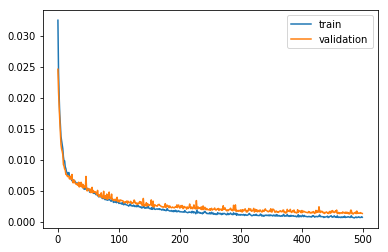

In [0]:
import matplotlib.pyplot as plt

plt.plot(np.arange(max_epoch), history.history['loss'], label='train')
plt.plot(np.arange(max_epoch), history.history['val_loss'], label='validation')
plt.legend()


In [0]:
configs

{'data': {'columns': ['RelativeTimeMilliseconds, NBP (Mean), Minute Volume'],
  'filename': 'case1_trends_3column.csv',
  'n_features': 1,
  'normalise': True,
  'sequence_length': 64,
  'train_test_split': 0.85},
 'model': {'layers': [{'filters': 10,
    'input_dim': 1,
    'input_timesteps': 80,
    'kernel_size': 20,
    'strides': 5,
    'type': 'conv1D'},
   {'filters': 20, 'kernel_size': 5, 'type': 'conv1D'},
   {'filters': 40, 'kernel_size': 5, 'type': 'conv1D'},
   {'type': 'flatten'},
   {'activation': 'linear', 'neurons': 1, 'type': 'dense'}],
  'loss': 'mse',
  'metrics': ['mse', 'acc'],
  'optimizer': 'adam',
  'save_dir': '/tmp'},
 'training': {'batch_size': 64,
  'epochs': 500,
  'feature_size': 80,
  'validation_split': 0.35}}

In [0]:
np.max(x)

0.3860074284666177

In [0]:
theModel.model.loss

'mean_squared_error'

In [0]:
for layer in configs['model']['layers']:
  print(layer)

{'filters': 10, 'input_dim': 1, 'input_timesteps': 80, 'kernel_size': 20, 'strides': 5, 'type': 'conv1D'}
{'filters': 20, 'kernel_size': 5, 'type': 'conv1D'}
{'filters': 40, 'kernel_size': 5, 'type': 'conv1D'}
{'type': 'flatten'}
{'activation': 'linear', 'neurons': 1, 'type': 'dense'}


In [0]:
from keras.models import model_from_json

model = theModel.model 

# serialize model to JSON
model_json = model.to_json()
with open("model.ramtin.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.ramtin.h5")
print("Saved model to disk")



Saved model to disk


In [0]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/data" "data"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
!cp model.ramtin.* data/

In [0]:
!git clone https://github.com/hossein20s/notebook_snippets 
!cd notebook_snippets; git pull

fatal: destination path 'notebook_snippets' already exists and is not an empty directory.
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/hossein20s/notebook_snippets
   bd6fb2f..77aabde  master     -> origin/master
Updating bd6fb2f..77aabde
Fast-forward
 modelutil.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [0]:
from notebook_snippets import modelutil


Using TensorFlow backend.


save and load models from yaml and json files defined. Everything stored in folder  <built-in function dir>
